In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from Libs.libs import llm
from langchain_core.tools import tool
from Libs.libs import *
# from models.Schema import DateModel
from typing import Literal
import pandas as pd

from Libs.libs import *

In [3]:
import pandas as pd
collection_name: str = os.getenv("RAG_GYM")

vector_store=Milvus(embedding_function=embeddings,connection_args={ "host":host, "port":port},collection_name=collection_name)
@tool
def rag_gym(query: str):
    """Used to answer the queries related to TATA Punch EV and its variants: Medium Range, Long Range."""
    context = vector_store.similarity_search(query, k=4)

    pprint.pprint(context)
    template = """You are given a context and a human query.
    Do not ever answer using your own knowledge base. 

    Human query is: {query}
    Context is :{context}
    Analyze the human query and context and answer the question related 
    Always ignore the place name mentioned in the query for each and every qeury as the place name does not matter .
    Your response should be precise, concise and not contain any irrelevant information.

    
    """
    prompt = ChatPromptTemplate.from_template(template=template)

    chain = RunnableMap({
        'query': lambda x: x['query'],
        "context": lambda x: vector_store.similarity_search(x['query'], k=6),
    }) | prompt | llm | string_parser

    res = chain.invoke({
        "query": query,
        })

    return res


def availabilityy(desired_date: str, doctor_name: str):
    desired_date_split = desired_date.split("T") or desired_date
    print("desired date is:", desired_date)
    df = pd.read_csv(f"./data/syntetic_data/availability.csv")
    date = desired_date_split[0]
    time = desired_date_split[1] if len(desired_date_split) > 1 else ""
    print(time)
    # query = doctor_name+ " for " + date + " at time: " +time
    query = doctor_name + " for " + date + "," + time
    # print(f"{df['date_slot'].apply(lambda x: x.split(' '))}", query)
    availability = pd.DataFrame()
    if time != "":
        availability = df[
            (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
            & (df["date_slot"].apply(lambda x: x.split(" ")[1]) == time)
            & (doctor_name == df["doctor_name"])
            & (df["is_available"] == True)
        ]
        if availability.empty:
            availability = df[
                (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
                & (doctor_name == df["doctor_name"])
                & (df["is_available"] == True)
            ]
        return query, availability
    availability = df[
        (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
        & (doctor_name == df["doctor_name"])
        & (df["is_available"] == True)
    ]
    print("---->>>>>>>", availability, ">>>-----", query)
    return query, availability


# def check_availability_by_doctor(self):
@tool
def check_availability_by_doctor(
    desired_date: str,
    doctor_name: Literal[
        "kevin anderson",
        "robert martinez",
        "susan davis",
        "daniel miller",
        "sarah wilson",
        "michael green",
        "lisa brown",
        "jane smith",
        "emily johnson",
        "john doe",
    ],
):
    # desired_date, doctor_name:Literal['kevin anderson','Ajeet','Rajesh','Shiva','Ganesh',]):
    """
    Check the availability of the doctor with the name of the doctor and date of availability provided
    """
    print()
    # print(desired_date)
    print("from check availability by doctor tool")
    query, availability = availabilityy(
        desired_date=desired_date, doctor_name=doctor_name
    )
    print("Tool entered with the query", query)
    # print(availability)
    template = """
    You have to answer the user query which is about the availability of a doctor inquired by patient. You are also given a context that contains the doctors available in that day and a time slot. Analyze and return the doctor name, date and available time slot. 
        Context inside double backticks:`{context}`
        Question inside triple backticks:{question}
        Response in markdown format without any backticks and in the context phrase just answer what is asked and if the doctor is not available for a particular time slot, recomend the other time slots.

        Your response should be very much conversational in such a way that you are a receptionist talking to a patient who is here to schedule an appointment.
        """
    prompt = ChatPromptTemplate.from_template(template)
    # print("context>>>>>>>>>>>>>>>>",database.similarity_search(query,k=5))
    chain = (
        RunnableMap(
            {"context": lambda x: availability, "question": lambda x: x["question"]}
        )
        | prompt
        | llm
        | string_parser
    )
    result = chain.invoke({"question": query})
    print("------------")
    mdprint(result)
    print("------------")
    return result



def availability_by_specialization(desired_date:str, specialization:str):
    desired_date_split = desired_date.split("T") or desired_date

    date =  desired_date_split[0] 
    time = desired_date_split[1] if len(desired_date_split) > 1 else "" 
    df = pd.read_csv(f"./data/syntetic_data/availability.csv")
    rows = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == date) & (df['specialization'] == specialization) & (df['is_available'] == True)].reset_index()
    available_specialization = rows[['date_slot', 'specialization', 'doctor_name']] 
      
    query = specialization+ " for " + date + "," +time
    print()
    print()
    print()
    print()
    return query, available_specialization
    

# def check_availability_by_specialization(self):

@tool
def check_availability_by_specialization(desired_date:str, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Check the availability of the doctor with specialization and date provided.
    """
    # print(self.senderId)
    print("from check availability by doctor tool")
    # specialization = "orthodontist"
    # desired_date = "2024-09-03"
    
    query, available_specialization = availability_by_specialization(desired_date=desired_date, specialization=specialization)
    print("Tool entered with the query", query)

    template = """
    You have to answer the user query in which patient is searching for a doctor of a particular specialization which is given in the query. You are also given a context that contains the doctors available in that day and a time slot. Analyze and return the doctor name, date and available time slot along with the specialization. 
        Context inside double backticks:`{context}`
        Question inside triple backticks:{question}
    Response in markdown format without any backticks and in the context phrase just answer what is asked and if the doctor is not available for a particular time slot, recomend the other time slots.
    Your response should be very much conversational in such a way that you are a receptionist talking to a patient who is here to schedule an appointment.

        """
    prompt = ChatPromptTemplate.from_template(template)
    # print("context>>>>>>>>>>>>>>>>",database.similarity_search(query,k=5))
    chain = RunnableMap({
        "context":lambda x: available_specialization,
        "question": lambda x: x['question']
    }) | prompt | llm | string_parser
    result = chain.invoke({'question':query})
    mdprint(result)
    return result
    # return check_specialization
    
        

    # @tool
    # def book_appointment( doctor_name:str, desired_time:str):
    #     """
    #     Schedule or Book an appointment for a doctor
    #     """
    #     print("Booking appointment tool")
    #     # app = patient_name + " " + desired_date + " "+ doctor_name + " " + specialization + " " + desired_time
    #     print("app")
        
    #     return "Booked "


    # @tool
    # def reschedule_appointment(patient_name:str,patient_id:str,desired_date:str, doctor_name:str, specialization:str, desired_time:str):
    #     """
    #     To reschedule an appointment which has already been scheduled to a new date
    #     """
    #     pass

@tool
def book_appointment(desired_date:str, desired_time:str,  doctor_name:str):
    """
    When the user wants to book an appointment for a doctor at a specified time.

    """
    # print(self.senderId)
    patient_id = "Check123Check"
    patient_name = "Ajeet Acharya"
    print("book tool activated", desired_date, " ", desired_time)
    availability = pd.DataFrame()
    specializations = pd.DataFrame()
    # if specialization =="":
    desired_date_time = f"{desired_date}T{desired_time}"
    _, availability = availabilityy(desired_date=desired_date_time, doctor_name=doctor_name)
    availability_new = availability[["date_slot","specialization","doctor_name"]]
    if len(availability) ==1:
        date_id_booking = availability.index[0]
        date_slot_booking = availability['date_slot'].iloc[0]
        time, date = date_slot_booking.split(" ")[0],  date_slot_booking.split(" ")[1]
        time = desired_time.split(":")
        final_time = f"{time[0]}:{time[1]}"
        if final_time == desired_time:
            doctor_name_booking = availability['doctor_name'].iloc[0]
            specialization_booking = availability['specialization'].iloc[0]
            data = pd.DataFrame({
                "patient_id": [patient_id],
                "doctor_time_id": [date_id_booking],
                "patient_name": [patient_name],
                "doctor_name": [doctor_name_booking],
                "appointment_date": [desired_date],
                "appointment_time": [final_time],
                "specialization": [specialization_booking],
            }
        )
            
            message = write_to_excel(data=data, date_id_booking=date_id_booking, patient_id=patient_id)
            print("Data written to Excel successfully!")
            return message
    else: 
        return f"The time slot {desired_time} is not available for {doctor_name}. Please select one of the.\n {availability_new}"
    # return book_appoint

def write_to_excel(data, date_id_booking, patient_id):
    data.to_excel("./Appointment/doctor_appointments.xlsx")  # 'index=False' prevents writing row numbers
    book_appointment_path = r"data/syntetic_data/availability.csv"
    df = pd.read_csv(book_appointment_path)
    column_no = date_id_booking-2
    df.loc[column_no, 'is_available'] = False 
    df.loc[column_no,'patient_to_attend'] = "Ajeet123"
    df.to_csv(book_appointment_path, index=False)
    return "Booking has been made sucessfully"



# def reschedule(self):
@tool
def reschedule(
        desired_date: str,
        doctor_name: str,
        desired_time: str,
    ):
        """
        To reschedule an appointment which has already been scheduled to a new date


        """
        # pass
        patient_id = "Check123Check"
        print("reschedule tool activated", desired_date, " ", desired_time)
        print("patient_id", patient_id)
        availability = pd.DataFrame()
        appointments_df = pd.read_excel("./Appointment/doctor_appointments.xlsx")
        appointment_to_reschedule = appointments_df[
            (appointments_df["patient_id"] == patient_id)
        ]
        if appointment_to_reschedule.empty:
            return f"Error: No appointment found for patient {patient_id}."
        original_date = f"{appointment_to_reschedule['appointment_date'].iloc[0]} {appointment_to_reschedule['appointment_time'].iloc[0]}"
        print("original date", original_date)
        # doctor_name = appointment_to_reschedule["doctor_name"].iloc[0]
        # if specialization =="":
        desired_date_time = f"{desired_date}T{desired_time}"
        _, availability = availabilityy(
            desired_date=desired_date_time, doctor_name=doctor_name
        )
        availability_new = availability[["date_slot", "specialization", "doctor_name"]]
        print("availability", availability)
        print("availability_new--->", availability_new)
        if not availability.empty:
            appointments_df.loc[
                appointments_df["patient_id"] == patient_id,
                ["appointment_time", "appointment_date"],
            ] = [desired_time, desired_date]

            # Write the updated appointment back to Excel
            appointments_df.to_excel("./Appointment/doctor_appointments.xlsx", index=False)

            message = update_availability_csv(
                original_date=original_date,
                desired_date=desired_date,
                desired_time=desired_time,
                patient_id=patient_id,
            )

            return f"Appointment rescheduled successfully for {desired_date} at {desired_time}.\n{message}"
        else:
            return f"Error: The time slot {desired_time} is not available for {doctor_name}. Please choose another slot."
    # return reschedule_appointment

def update_availability_csv(
    original_date, desired_date, desired_time,patient_id
):

    availability_csv_path = r"data/syntetic_data/availability.csv"
    df = pd.read_csv(availability_csv_path)
    desired_date_time = f"{desired_date} {desired_time}"

    df.loc[ df["date_slot"].str.contains(original_date),
        ["is_available", "patient_to_attend"]
    ] = [True, ""]

    # Update the new time slot to be unavailable (False) and assign the patient to attend
    df.loc[df["date_slot"].str.contains(desired_date_time),
        ["is_available", "patient_to_attend"],
    ] = [False, patient_id]

    # Write the updated DataFrame back to the CSV file
    df.to_csv(availability_csv_path, index=False)

    return "Doctor's availability updated successfully."


In [4]:
tools_available = [check_availability_by_specialization, check_availability_by_doctor]

## Agent Node

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)




def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

## Supervisor agent

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Appointments", "Rag"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Analyze the user query well and then choose members. You do not need to go to all the members for a query When finished,"
    " respond with FINISH. Only invoke one worker at once."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal["Appointments", "Rag", "FINISH"]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# llm = ChatOpenAI(model="gpt-4o")


def supervisor_agent_make(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [7]:
from Tools.tools_init_ import GetCustomTools

toolsInstance = GetCustomTools()
tools_available = toolsInstance.get_tools()


In [1]:
# import functools
# import operator
# from typing import Sequence
# from typing_extensions import TypedDict

# from langchain_core.messages import BaseMessage

# from langgraph.graph import END, StateGraph, START
# from langgraph.prebuilt import create_react_agent


# # The agent state is the input to each node in the graph



# Appointments = create_react_agent(llm, tools=[check_availability_by_doctor, check_availability_by_specialization,book_appointment, reschedule ], )
#                                 #   inter=)
# # Appointments = create_agent(llm=llm,tools=[check_availability_by_doctor, check_availability_by_specialization,book_appointment, reschedule ],     system_message="You are an agent who is responsible for checking the availability of doctor based on doctor's name or specialization , booking appointments or rescheduling appointments of patients.",
# # Rag = create_agent(llm=llm,tools=[rag_gym],system_message="You are an agent who is responsible for answering questions related to TATA Punch Ev.",)
# Rag = create_react_agent(llm, tools=[rag_gym])
# Appointments_node = functools.partial(agent_node, agent=Appointments, name="Appointments")
# Rag_node = functools.partial(agent_node, agent=Rag, name="Rag")

# # # NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
# # code_agent = create_react_agent(llm, tools=[python_repl_tool])
# # code_node = functools.partial(agent_node, agent=code_agent, name="Coder")
# class AgentState(TypedDict):
#     # The annotation tells the graph that new messages will always
#     # be added to the current states
#     messages: Annotated[Sequence[BaseMessage], operator.add]
#     # The 'next' field indicates where to route to next
#     next: str

# workflow = StateGraph(AgentState)
# workflow.add_node("Appointments", Appointments_node)
# workflow.add_node("Rag", Rag_node)
# workflow.add_node("supervisor_agent", supervisor_agent_make)

NameError: name 'llm' is not defined

In [13]:
# for member in members:
#     # We want our workers to ALWAYS "report back" to the supervisor when done
#     workflow.add_edge(member, "supervisor_agent")
workflow.add_edge("Appointments", "supervisor_agent")
workflow.add_edge("Rag", "supervisor_agent")


# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}

conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor_agent", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.add_edge(START, "supervisor_agent")

graph = workflow.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `None` already exists for node `supervisor_agent`

In [10]:
conditional_map

{'Appointments': 'Appointments', 'Rag': 'Rag', 'FINISH': '__end__'}

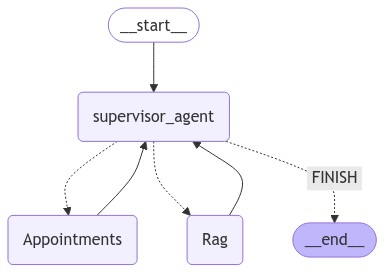

In [11]:
# from Agent.agent_take2 import *
from Libs.libs import *
# from graph import  graph
from IPython.display import Image, display



display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
query = "Book an appointment with  doctor kevin anderson available on september 3 2024 at 8 aM"
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=query)
        ]
    },
        {"recursion_limit": 100}

):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor_agent': {'next': 'Appointments'}}
----

from check availability by doctor tool
desired date is: 2024-09-03

---->>>>>>>              date_slot specialization     doctor_name  is_available  \
4262  2024-09-03 08:00   orthodontist  kevin anderson          True   
4263  2024-09-03 08:30   orthodontist  kevin anderson          True   
4269  2024-09-03 11:30   orthodontist  kevin anderson          True   
4270  2024-09-03 12:00   orthodontist  kevin anderson          True   
4271  2024-09-03 12:30   orthodontist  kevin anderson          True   
4272  2024-09-03 13:00   orthodontist  kevin anderson          True   
4274  2024-09-03 14:00   orthodontist  kevin anderson          True   
4275  2024-09-03 14:30   orthodontist  kevin anderson          True   
4276  2024-09-03 15:00   orthodontist  kevin anderson          True   
4277  2024-09-03 15:30   orthodontist  kevin anderson          True   
4279  2024-09-03 16:30   orthodontist  kevin anderson          True   

     patient_t

In [ ]:



from Libs.libs import *


from Tools.availability_by_doctor import *
from Tools.availability_by_specialization import *
from Tools.booking import book_appointment

class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]
    senderId:str
    history:str
    
    
tools_available = [book_appointment,check_availability_by_doctor, check_availability_by_specialization]
# tool = [mercedes_tool]
tool_node = ToolNode(tools=tools_available)
model = llm.bind_tools(tools = tools_available, strict=True)

def read_human_feedback(state):
    # if state['messages'][-1].tool_calls == []:
    #     logger.info("AI: "+ state['messages'][-1].content)
    #     user_msg = input("Reply: ")
    
    
    # history = {"history":[]}
    # history = getData("abcsdd")
    # if history is None:
    #     history = {'history':[]}
    # history_new = {"human_feedback":f"{state['messages'][0].content}", "ai":f"{state['messages'][-1].content}"}



    # history = history_new.append(history['history'])
    # history['history'].append(history_new)
    # print(history)

        
        
    
    # history['history'].append(history_new)
    
    # setData(state['senderId'], history)
    
    # if len(history['history'])>4:
    #     length = len(history['history']) - 4
    #     for i in range(length):
    #         history["history"].pop(0)
    
    # a = getData("abcsdd")
    # combined_history.append(a)
    # {"history":combined_history}
        
    
    
    # print()
    # print(state)
    # print("history",history)
    # print()
    return state
    #     pass

def call_model(state: MessagesState):
    
    
    
    print("From call_model the state is:",state['senderId'])
    s = getData(state["senderId"])
    state["history"] = s
    

    # history = {"human_feedback":state["messages"][1], "AI":"This is ai response"}
    messages = [SystemMessage(content=f"You are helpful assistant.\n.As reference, today is {datetime.now().strftime('%Y-%m-%d %H:%M, %A')}\nKeep a friendly, professional tone.\nAvoid verbosity.\nConsiderations:\n- Don´t assume parameters in call functions that it didnt say.\n- MUST NOT force users how to write. Let them write in the way they want.\n- The conversation should be very natural like a secretary talking with a client.\n- Call only ONE tool at a time.")] + state['messages']
    # messages = [SystemMessage(content="You are a helpful assistant. As reference, today is {datetime.now().strftime('%Y-%m-%d %H:%M, %A')}. Always use tools to answer the queries")]

    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "human_feedback"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "human_feedback"




def should_continue_with_feedback(state: MessagesState) -> Literal["agent", "FINISH", "human_feedback"]:
    messages = state['messages']
    last_message = messages[-1]
    if isinstance(last_message, dict):
        if last_message.get("type","") == 'human_feedback':
            return "agent"
    if (isinstance(last_message, HumanMessage)):
        return "agent"
    if (isinstance(last_message, AIMessage)):
        return "FINISH"
    return "FINISH"



def graph(query:str, senderId:str):
    workflow = StateGraph(MessagesState)
    workflow.add_node("agent",call_model)
    workflow.add_node("tools",tool_node)
    workflow.add_node("human_feedback", read_human_feedback)


    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {"human_feedback":"human_feedback",
        "tools":"tools"}
    )
    workflow.add_conditional_edges(
        "human_feedback",
        should_continue_with_feedback,
        {"agent":"agent","FINISH":END}
    )

    workflow.add_edge("tools","agent" )


    workflow.set_entry_point('agent')



    graph = workflow.compile()
    inputs = {"messages":[HumanMessage(content=query)], "senderId":senderId}

    for response in graph.stream(inputs):
        try:
            if "__end__" not in response:
                print(response)
                # if 'human_feedback' in response:
                token_usage =response['human_feedback']['messages'][-1].response_metadata['token_usage']
                final_response =  response['human_feedback']['messages'][-1].content
                    
                print("-----")
                # history = {"human_feedback":query, "ai":final_response}
                return {"result": final_response, "token_usage":token_usage}
        except Exception as e:
            print("error", e)





In [1]:
from Tools.tools_init_ import *
from Libs.libs import *

from Libs.libs import llm
from Libs.libs import llm


import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from Redis.utilis import RedisSaver
from Agent.supervisor_agent import agent_node, supervisor_agent_make

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from Libs.libs import *
from Tools.tools_init_ import GetCustomTools
from Tools.availability_by_doctor import check_availability_by_doctor
from Tools.availability_by_specialization import check_availability_by_specialization
from Tools.booking import book_appointment
from Tools.reschedule import reschedule
from Tools.ragAgent import rag_tool


In [1]:
from Tools.tools_init_ import *
from Libs.libs import *

from Libs.libs import llm
from Libs.libs import llm


import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from Redis.utilis import RedisSaver
from Agent.supervisor_agent import agent_node, supervisor_agent_make

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from Libs.libs import *
from Tools.tools_init_ import GetCustomTools
from Tools.availability_by_doctor import check_availability_by_doctor
from Tools.availability_by_specialization import check_availability_by_specialization
from Tools.booking import book_appointment
from Tools.reschedule import reschedule
from Tools.ragAgent import rag_tool, create_custom_agent

query = "book an appointment with doctor kevin anderson for october 3 2024 16:00?"



def read_human_feedback(state):
    return state

class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

        
def should_continue(state: MessagesState) -> Literal["Rag","Appointments"]:
    print("Inside should continue", state['next'])
    # if state['next'] == "FINISH":
        # return "human_feedback"
    return state['next']
    # messages = state['messages']
    # print("message",messages)
    # last_message = messages[-1]
    # print("from should continue",last_message)
    # if isinstance(last_message,routeResponse):
    #     return f"{last_message.next}"
    # return last_message

# def should_continue_with_feedback(state: MessagesState) -> Literal['supervisor_agent', "FINISH", "human_feedback"]:
    # messages = state['messages']
    # last_message = messages[-1]
    # if isinstance(last_message, dict):
    #     if last_message.get("type","") == 'human_feedback':
    #         return "supervisor_agent"
    # if (isinstance(last_message, HumanMessage)):
    #     return "supervisor_agent"
    # if (isinstance(last_message, AIMessage)):
    #     return "FINISH"
    # return "FINISH"
       
        
toolsInstance = GetCustomTools()
tools_available = toolsInstance.get_tools()

class routeResponse(BaseModel):
    next: Literal["Appointments", "Rag", "FINISH"]

from Tools.ragAgent import create_custom_agent
Appointments_agnet = create_custom_agent(prompt="""You are an intelligent agent that answers queries related to the appointment with doctor based on doctor name, specialization, schedule appointment and reschedule appoinments.""", tools=tools_available, )
Appointments_node = functools.partial(agent_node, agent=Appointments_agnet, name="Appointments")

Rag_agent = create_custom_agent(prompt="""You are an intelligent agent that answers queries related to TATA Punch EV vehicles and its variants.""", tools=[rag_tool] )

Rag_node = functools.partial(agent_node, agent=Rag_agent, name="Rag")
workflow = StateGraph(AgentState)
workflow.add_node("Appointments", Appointments_node)
workflow.add_node("Rag", Rag_node)
workflow.add_node("supervisor_agent", supervisor_agent_make)
# workflow.add_node("human_feedback", read_human_feedback)

# workflow.add_edge("Appointments", "supervisor_agent")
conditional_map = {'Appointments': 'Appointments', 'Rag': 'Rag', 'FINISH': '__end__'}
# workflow.add_conditional_edges("supervisor_agent", lambda x: x["next"], conditional_map)

workflow.add_conditional_edges(
"supervisor_agent",
should_continue,
        {
            "Rag":"Rag",
            "Appointments":"Appointments",
            "FINISH":END
            }
    )
# workflow.add_conditional_edges(
#     "human_feedback",
#     should_continue_with_feedback,
#     {"supervisor_agent":"supervisor_agent","FINISH":END}
# )

workflow.add_conditional_edges(
    "Appointments",
    should_continue_with_feedback,
    {"supervisor_agent":"supervisor_agent"}
)



workflow.add_conditional_edges(
    "Rag",
    should_continue_with_feedback,
    {
        "supervisor_agent":"supervisor_agent",
                }
)
        
        
        
workflow.add_edge(START, "supervisor_agent")
graph = workflow.compile()



        # from Agent.agent_take2 import *
from Libs.libs import *
# from graph import  graph
from IPython.display import Image, display



display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

for s in graph.stream({"messages": [HumanMessage(content=query)]},{"recursion_limit": 100}):
    if "__end__" not in s:
        # if 'human_feedback' in s:
            # print(s['human_feedback']['messages'])
            # break
        print(s)
        print("----")
    else:
        print(s)


NameError: name 'should_continue_with_feedback' is not defined

In [ ]:

for s in graph.stream({"messages": [HumanMessage(content=query)]},{"recursion_limit": 100}):
    if "__end__" not in s:
        print(s)
        print("----")
    else:
        print(s)
